In this notebook we compute spectrograms for the 2 hour period during the colar eclipse. First we read the file containing the merged wave stream.

In [1]:
# visualization packages
import matplotlib.pyplot as plt
from matplotlib import mlab
import pylab as pl
%matplotlib inline

In [2]:
# data manipulation packages
import numpy as np
import pandas as pd

In [3]:
# reading mseed file processing library
import obspy
from obspy import UTCDateTime

In [4]:
merged_sounds = obspy.read('../data/merged_hydrophone.mseed')

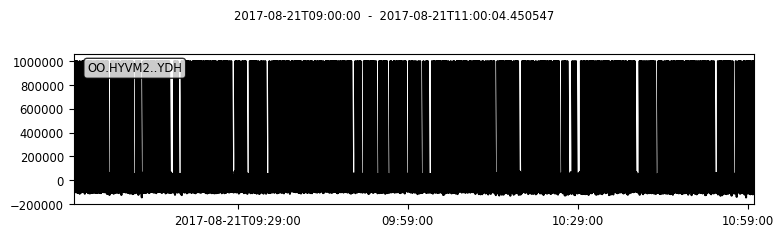

In [5]:
merged_sounds.plot()

Computing the spectrogram for the whole stream would have been great but too memory consuming. So we can only compute spectrogram on small chunks of the stream. We can extract a slice from the stream using the `slice` function.

We can extract the data points and the corresponding times into `numpy` arrays. 

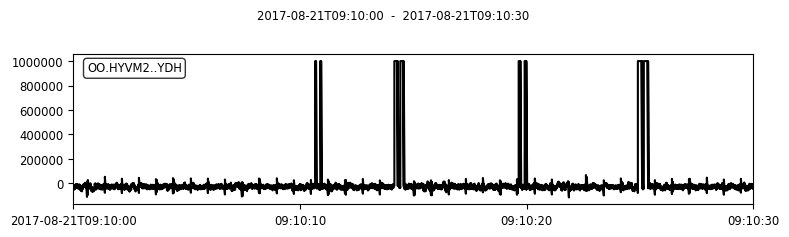

In [6]:
dt = UTCDateTime("2017-08-21T09:10:00")
sl = merged_sounds.slice(dt,dt+30)
sl.plot()

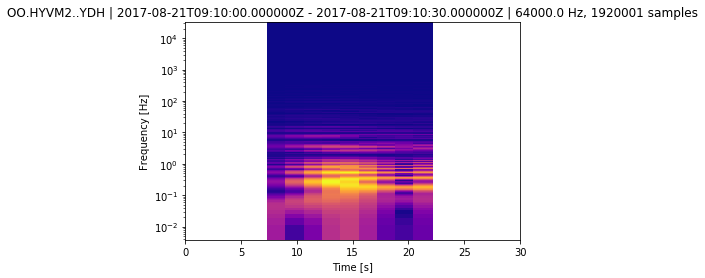

[None]

In [7]:
sl.spectrogram(log=True,cmap = 'plasma',wlen = 20)

Unfortunately, the `obspy` spectrogram function does not return the actual values of the spectrogram (it can return only the plot of the spectrogram). So instead we can use scipy to extract it.

In [90]:
# calculate number of frames in clip
secs = 5
freq = 64000
framesPerClip= secs*freq

In [108]:
params = {'NFFT':1024, 'Fs':64000, 'noverlap':5}
P, freqs, bins = mlab.specgram(merged_sounds[0].data[:framesPerClip], **params)
spec_dim = P.shape

In [92]:
def PlotSpecgram(P, freqs, bins):
    """Spectrogram"""
    Z = np.flipud(P) # flip rows so that top goes to bottom, bottom to top, etc.
    xextent = 0, np.amax(bins)
    xmin, xmax = xextent
    extent = xmin, xmax, freqs[0], freqs[-1]

    im = pl.imshow(np.log(Z[:,:]), extent=extent,cmap = 'plasma')
    pl.axis('auto')
    pl.xlim([0.0, bins[-1]])
    pl.ylim([0, freqs[-1]])

In [93]:
PlotSpecgram(P,freqs,bins)

#### Creating and storing spectrograms

Our next goal is to create a spectrogram for each clip of 15s. We can obtain the spectrogram through the `matplotlib.specgram` function. This step is expensive and generates a lot of data. Ideally we should run it in parallel. 

We start with the simplest approach is to write a loop and apply the function to each subset of the data. We convert each spectrogram to a feature vector and store it in a line of a csv file of a file `spectrogram.csv`. Note, this step will take a while and it will create a file of size several GB. Make sure you have enough space, RAM, and time to run the next operation.


In [95]:
spectrogram_list = []
with open('../data/spectrogram.csv', 'a') as f:
    for i in range(0,len(merged_sounds[0].data),framesPerClip):
        P, freqs, bins = mlab.specgram(merged_sounds[0].data[i:i+framesPerClip], **params)
        pd.DataFrame(P.ravel()).T.to_csv(f, header=False, mode = 'a')
    
    
    
    

The next spep is to read the feature matrix from the .csv file. If do not have enough RAM to load the dataset we can try to read it as a `dask` object. 

In [86]:
# import dask.dataframe as dd
# from da

In [87]:
# from dask.array import linalg

In [88]:
# X = dd.read_csv('../data/spectrogram.csv',header = None).head(n=1)

If this takes takes too long, we can try reading it line by line (and store only first few lines).

We will read the spectrograms line by line. If running out of RAM, we can limit to read only nofLines.

In [97]:
# reading line by line
nofLines = 2000
rows = []
with open('../data/spectrogram.csv') as f:
    l = 0
    for line in f:
        res = line.split(',') 
        rows.append(np.array(res).astype('float')[1:])
        l = l + 1
        if l>nofLines:
            break

        
        

In [98]:
# stack all but the last one (which contains less points)
X = np.stack(tuple(rows[:-1]))

In [99]:
X[:,:].astype('float').shape

(1440, 161082)

### Dimensionality Reduction

In [100]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(1440, 2)

In [103]:
plt.scatter(X_embedded[:,0],X_embedded[:,1])

In [104]:
#res = dask_sounds.map_blocks(mlab.specgram).compute()

In [105]:
#res,freqs,bins = plt.specgram(merged_sounds[0].data[:framesPerClip], NFFT=256, Fs=64000, noverlap=192)

In [106]:
from matplotlib import offsetbox
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
# Scale and visualize the embedding vectors
def plot_embedding(X, X_embedded, title=None):
    x_min, x_max = np.min(X_embedded, 0), np.max(X_embedded, 0)
    X_embedded = (X_embedded - x_min) / (x_max - x_min)

    plt.figure(figsize = (10,10))
    ax = plt.subplot(111)
    for i in range(X_embedded.shape[0]):
        plt.text(X_embedded[i, 0], X_embedded[i, 1], 'o',
                 #color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X_embedded.shape[0]):
            dist = np.sum((X_embedded[i,:] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X_embedded[i,:]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(np.log(X[i,:].reshape(spec_dim)),zoom = 0.05, cmap='plasma'),
                X_embedded[i,:])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

<IPython.core.display.Javascript object>


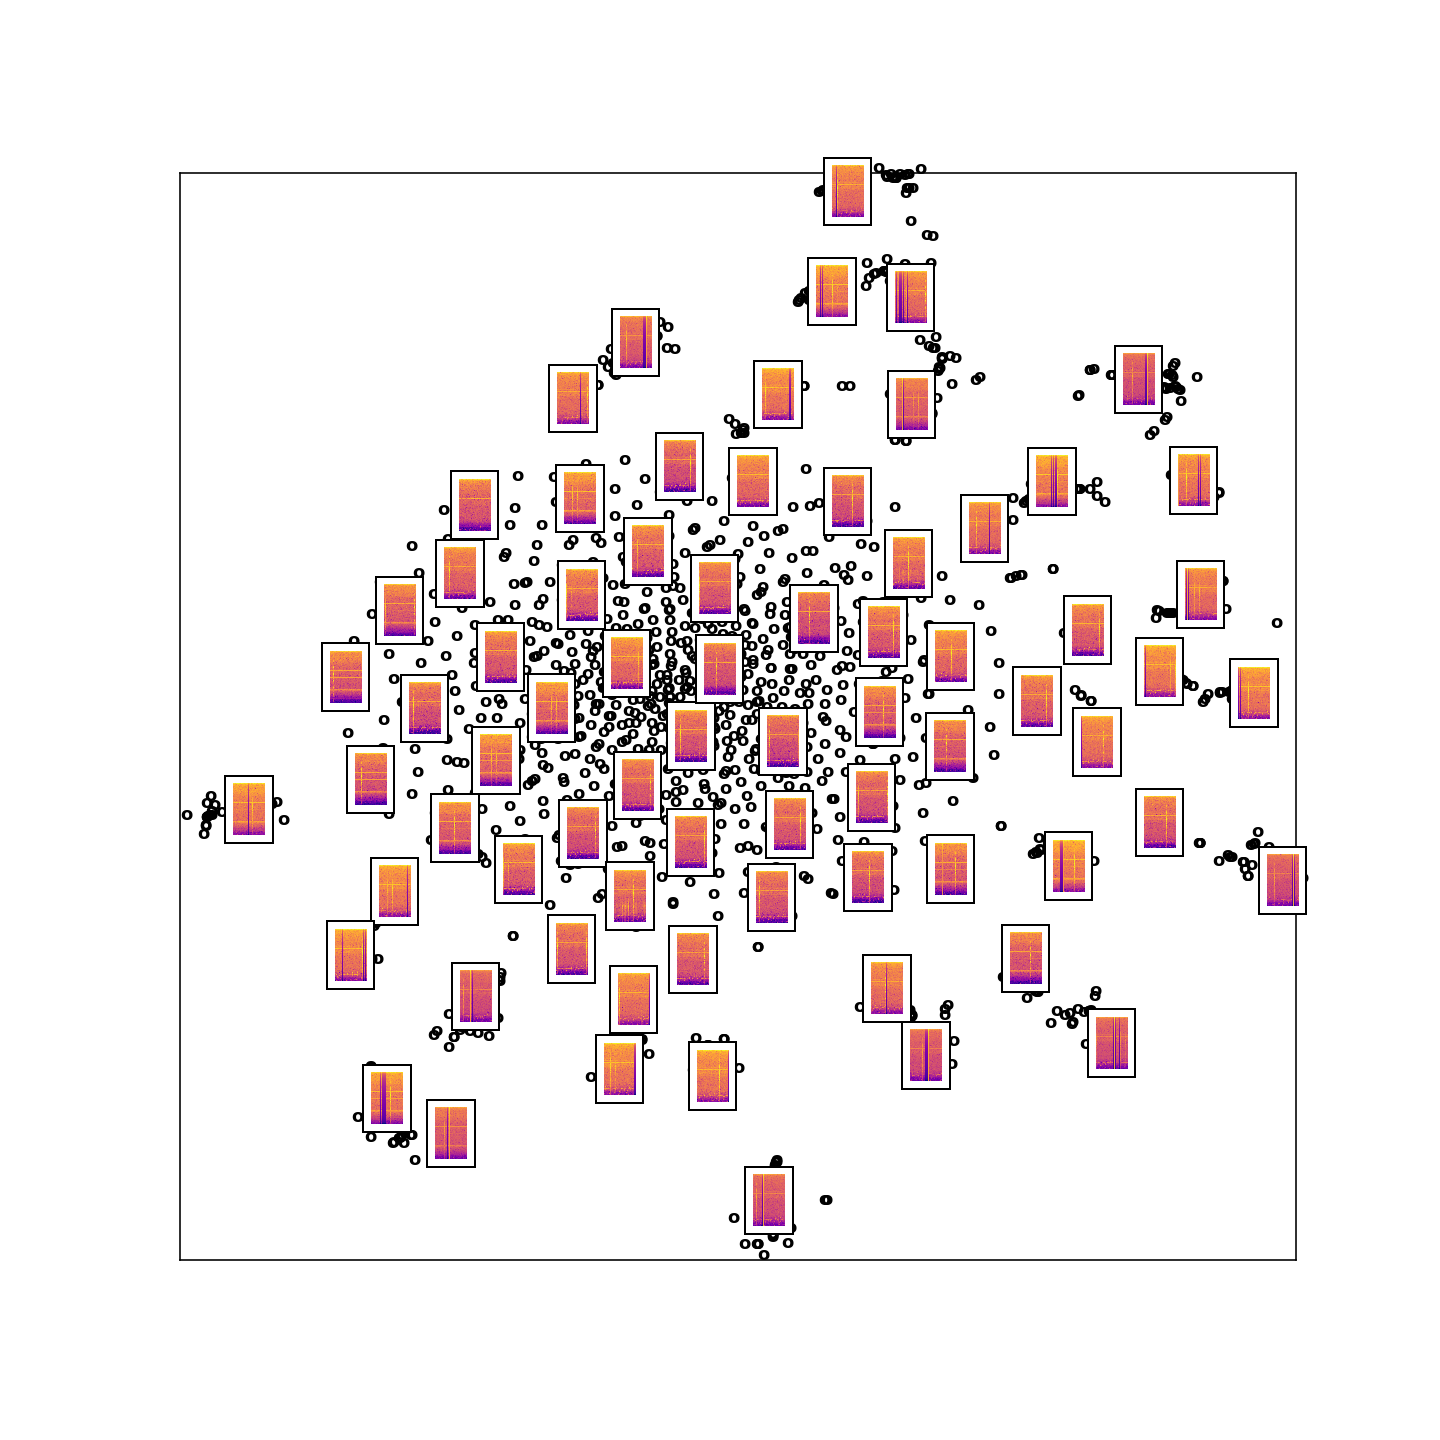

/home/ubuntu/anaconda/envs/hydrophone/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


In [107]:
%matplotlib notebook
plot_embedding(X, X_embedded)
plt.show()

Need shorter clips, better time invariance similarity, allow for specifying the frequency range.

----
### Extra (do not run)

#### Save data to an hdf5 format

In [ ]:
import h5py

Extract the data and the times.

In [ ]:
times = merged_sounds[0].times()
trace = merged_sounds[0].data

In [ ]:
f = h5py.File('merged_hydrophone.hdf5','w')

In [ ]:
f.close()
f.create_dataset('trace',trace,dtype="uint16")
f.close()

In [ ]:
f.close()
f.create_dataset('times',times,dtype="uint16")
f.close()

In [ ]:
#for signal,key in zip(merged_sounds.data[:10]):
#    P = mlab.specgram(trace,**params)
#    dset = f.create_dataset(key, data=P)

In [ ]:
array = np.vstack((times,trace))

In [ ]:
np.save('times.npy',times)

In [ ]:
np.save('trace.npy',trace)

In [ ]:
import dask.array as da

In [ ]:
dask_sounds = da.from_array(merged_sounds[0].data, chunks=(framesPerClip, ))

In [ ]:
import pandas as pd

In [ ]:
hydrophone_pd = pd.DataFrame()

In [ ]:
hydrophone_pd['time'] = times 

In [ ]:
hydrophone_pd['trace'] = trace